In [1]:
from torchvision import datasets, transforms # for loading and transforming image datasets
from torch.utils.data import DataLoader # for loading datasets in batches
import torch # main PyTorch library
import torch.nn as nn  # for neural network modules
import torch.nn.functional as F # for activation functions
import torch.optim as optim # for optimization algorithms

In [2]:
# Define transformations and train/test datasets

transform = transforms.Compose([         # this transform variable will preprocess the data into tensors and then normalize it.
    transforms.ToTensor(),              # converts images to PyTorch tensors. Reminder, a tensor is a multi-dimensional array.
    transforms.Normalize((0.5,), (0.5)) # normalizes the tensor with mean 0.5 and std 0.5
])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform) # gets the MNIST training dataset and applies the transform. root is where the data will be stored.
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform) # gets the MNIST test dataset, applies the transform. 

train_loader = DataLoader(train_data, batch_size=64, shuffle=True) # Dataloader is a function that loads data in batches. Here, batch size is 64 and data is shuffled.
test_loader = DataLoader(test_data, batch_size = 64, shuffle=False) # we dont shuffle test data because we want to evaluate on the same order each time.

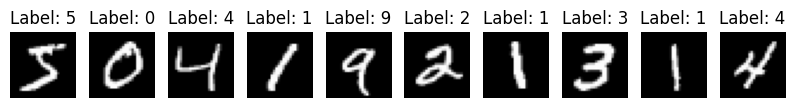

In [3]:
# Visualize the data in a DataFrame
import pandas as pd
df = pd.DataFrame(train_data.data.numpy().reshape(-1, 28*28)) # reshape 28x28 images to 784 length vectors for DataFrame
df['label'] = train_data.targets.numpy() # add labels to DataFrame
# Visualize the train data as images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axes[i].imshow(train_data.data[i], cmap='gray')
    axes[i].set_title(f'Label: {train_data.targets[i].item()}')
    axes[i].axis('off')
plt.show()


In [4]:
# Define CNN architecture
# conv1 --> conv2 --> max pool --> fc1 --> fc2
class CNN(nn.Module): # define a class CNN that inherits from nn.Module
    def __init__(self): # we use the __init__ method to define the layers of the CNN. self refers to the instance of the class.
        super(CNN, self).__init__()
    # Convolutional Layers
        self.conv1 = nn.Conv2d(          # Conv layer 1
            in_channels=1,
            out_channels=32,
            kernel_size=3, # filter size 3x3
            stride=1,
            padding=1
            )
        self.conv2 = nn.Conv2d(         # Conv layer 2
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1
            )
    

    # FC Layers
        self.fc1 = nn.Linear(           # Fully connected layer 1
                in_features=64 * 14 * 14, # after max pooling, image size is halved from 28x28 to 14x14. 14x14 due to stride = 2
                out_features=128 # hidden layer with 128 neurons # 128 comes from experimentation
            )
        self.fc2 = nn.Linear(           # Fully connected layer 2
                in_features=128, # from previous layer
                out_features=10 # 10 output classes for digits 0-9
            )
        
    
    ## FORWARD PROPAGATION
    def forward(self, x): # forward method defines the forward pass of the CNN... shows how x (the data) flows through the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # max pooling with kernel size 2x2 and stride 2 after conv layers to reduce number of parameters
        x = x.view(-1, 64 * 14 * 14) # flatten the tensor for the fully connected layers.. must flatten before fc layers
        x = self.fc1(x)
        x = F.relu(x) # need non-lin activation layers after each layer for model to learn complex relationships.
        x = self.fc2(x)
        return x

In [5]:
# Initialize model, define loss function (cross entropy loss) and the optimizer (adam, sgd, etc)
model = CNN()
criterion = nn.CrossEntropyLoss() # cross entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with learning rate 0.001


In [6]:
from tqdm import tqdm # for progress bar
# Training Loop
epochs = 1
for epoch in range(epochs):
    model.train() # set model to training mode
    running_loss = 0.0 # to accumulate loss over batches
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False): # iterate over batches from train_loader. # images is a batch of images, labels are the corresponding labels
        # train_loader has a label images and labels for each batch. Here is what it looks like inside train_loader
        optimizer.zero_grad() # no gradient before backpropagation
        outputs = model(images) # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # backpropagation
        optimizer.step() # update weights
        running_loss += loss.item() # accumulate loss
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}') # print average loss for the epoch


Epoch [1/1], Loss: 0.1371


In [7]:
# Evalulation
model.eval() # set the model into evaluation mode
correct = 0
total = 0

with torch.no_grad(): # no gradient computation during evaluation
    for images, labels in test_loader: # iterate over test data
        images, labels = images, labels # get images and labels from the batch
        outputs = model(images) # forward pass
        _, predicted = torch.max(outputs.data, 1) # get the index of the max log-probability # the likelihood for each class
        total += labels.size(0) # total number of labels 
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 98.58%


In [8]:

all_labels = []
all_predicted = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.numpy())
        all_predicted.extend(predicted.numpy())

# save all labels and predictions to a CSV file for further analysis
df_results = pd.DataFrame({'True Label': all_labels, 'Predicted Label': all_predicted})
df_results.to_csv('mnist_cnn_results.csv', index=False)


